In [1]:
"""
notebook: 1.1.-leibold-data-modeling_randomForest_binary.jpynb

author: Christian Leibold

created/updated at: 2025-12-06

intention: use pipline preprocess data to model withh over- and undersampling + random forest model to create a first baseline model.
           REDUCED DIMENSIONALITY
           PRUNED modalities

content:
---------
-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook 
-> preprocessing with preprocessing_pipeline WITHOUT aggregation
-> pipline with over- and undersampling resampling + random forest model
-> RandomSearchCV + stratifedKFold to optimize hyperparamethers
-> save fitted model and pipeline to local storage
-> PCA to check class seperability
-> first SHAP analysis

"""

'\nnotebook: 1.5.-leibold-data-modeling_randomForest.jpynb\n\nauthor: Christian Leibold\n\ncreated/updated at: 2025-11-30\n\nintention: create preprocessing pipeline to prepare data from concat joblib. \n           use random forest model with smote to create a first baseline model. \n\ncontent:\n---------\n-> reads in joblib with concatenated data from prior process stept with csv-files for 2019-2024 as base for this notebook \n-> create a pipeline with most important preprocessing steps\n-> NEW: use GridSearchCV to optimize hyperparamethers\n-> create random forest model + smote resampling\n-> save model to local storage\n\n'

In [20]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
#from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
#from road_accidents_pipeline import RearrangeCatCols             # bundle veh classes together to higher-tier classes
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# encoder
from sklearn.preprocessing import OneHotEncoder, SplineTransformer
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols, print_col_categories
import time



In [21]:
# -------------------------------------------------------------------------------------------------
# read in joblib with concatenated data and define which data to keep
# -------------------------------------------------------------------------------------------------
df_ori = load('C:/Users/Christian/Documents/1.0-leibold-data-preprocessing_aggr.joblib')
#df = df_ori.loc[df_ori['acc_year'].between(2019, 2023)]
#df = df.loc[(df['acc_year']==2024) | (df['acc_year']==2023)]
#df = df_ori.sample(n=20000)
df = df_ori

print("original shape:", df_ori.shape)
print("kept shape:", df.shape)
display(df.head(3))

original shape: (692159, 45)
kept shape: (692159, 45)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection,loca_road_counts,loca_max_speed_dif
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,3,10.0,1,2.0,1.0,1,70.0,0,1,0.0


In [22]:
# transform target to binary variable
#df['ind_severity'] = df['ind_severity'].replace({1: 0, 3: 2, 4: 2})
#df.loc[df['ind_severity'].isin([3, 4]), 'ind_severity'] = 2
df['ind_severity'] = df['ind_severity'].map(lambda x: 0 if x == 1 else 1)
df['ind_severity'].value_counts(normalize=True)

ind_severity
1    0.587004
0    0.412996
Name: proportion, dtype: float64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692159 entries, 0 to 733874
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 692159 non-null  int64         
 1   ind_place               692159 non-null  int64         
 2   ind_cat                 692159 non-null  int64         
 3   ind_severity            692159 non-null  int64         
 4   ind_sex                 692159 non-null  int64         
 5   ind_trip                692159 non-null  int64         
 6   ind_secu1               691305 non-null  Int64         
 7   ind_secu2               415207 non-null  Int64         
 8   ind_location            379506 non-null  Int64         
 9   ind_action              409030 non-null  Int64         
 10  ind_year                692159 non-null  int64         
 11  ind_age                 692159 non-null  Int64         
 12  ind_age_group           692159 non-

In [24]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (553727, 44)
y_train shape: (553727,)
X_test shape: (138432, 44)
y_test shape: (138432,)


In [25]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    698
ind_secu2                 221591
ind_location              249981
ind_action                226445
acc_ambient_lightning         10
acc_atmosphere                30
acc_intersection              22
acc_collision_type          2988
veh_impact                   221
veh_maneuver               31742
loca_road_lanes             7898
loca_road_view                45
loca_road_surface_cond        93
loca_max_speed              7717
loca_max_speed_dif          7717
dtype: int64


In [26]:
# pruning of modalities
mapping_dicts = {
    "acc_ambient_lightning": {
        1: 1,  # day
        2: 2,  # twilight
        3: 3, 4: 3, 5: 3  # night
    },

    "acc_intersection": {
        1: 1,  # no intersection
        2: 2, 3: 2, 4: 2,  # simple / standard intersection
        6: 3,  # roundabout
        5: 4, 7: 4, 8: 4, 9: 4  # other
    },

    "acc_atmosphere": {
        1: 1,  # clear
        2: 2, 3: 2,  # rainy
        8: 3,  # cloudy
        4: 4, 5: 4, 6: 4, 7: 4, 9: 4  # adverse / special
    },

    "acc_collision_type": {
        1: 1,  # frontal
        2: 2,  # rear
        3: 3,  # side
        4: 4, 5: 4, 6: 4, 7: 4  # multi / chain / other
    },

    "ind_place": {
        1: 1,  # driver
        **{i: 2 for i in range(2, 10)},  # passenger
        10: 3  # pedestrian / external
    },

    "ind_cat": {
        1: 1,  # driver
        2: 2,  # passenger
        3: 3, 4: 3  # pedestrian
    },

    "ind_sex": {
        1: 1,  # male
        2: 2,  # female
        -1: 2  # female (wrong/missing recoded)
    },

    "ind_trip": {
        1: 1, 2: 1,  # commuting
        3: 2,  # shopping
        4: 3,  # professional
        5: 4,  # leisure
        0: 5, 9: 5  # other
    },

    "ind_secu1": {
        0: 0,  # no equipment
        1: 1,  # seatbelt
        2: 2,  # helmet
        3: 3, 4: 3, 9: 3,  # other / child / vest
        8: 4, -1: 4  # unknown / not reported
    },

    "veh_cat": {
        10: 1, 7: 1,  # light vehicles (car)
        2: 2, 31: 2, 32: 2, 34: 2, 35: 2, 36: 2, 41: 2, 42: 2, 43: 2, 33: 2, 30: 2,  # 2-wheeler
        80: 3, 1: 3,  # bicycle / E-bike
        13: 4, 15: 4, 38: 4, 39: 4, 40: 4, 14: 4, 37: 4,  # heavy / public vehicles
        60: 5, 50: 5,  # micromobility (EDP)
        3: 6, 0: 6, 17: 6, 99: 6, 16: 6, 20: 6, 21:6  # other
    },

    "veh_fixed_obstacle": {
        3: 1, 7: 1, 9: 1, 10: 1, 11: 1, 12: 1, 14: 1, 15: 1, 16: 1, 1: 1, 2: 1, 4: 1, 5: 1, 6: 1,  # vehicle / barrier / wall
        8: 2, 13: 2, 17: 2,  # pole / ditch / culvert
        0: 0  # no fixed obstacle
    },

    "veh_moving_obstacle": {
        1: 1,  # pedestrian
        2: 2,  # vehicle
        4: 3, 5: 3, 6: 3, 9: 3,  # other
        0: 0  # none
    },

    "veh_impact": {
        1: 1, 2: 1, 3: 1,  # front
        4: 2, 5: 2, 6: 2,  # rear
        7: 3, 8: 3,  # side
        9: 4,  # multiple / roll-over
        0: 0  # no impact
    },

    "veh_maneuver": {
        1: 1, 2: 1,  # straight / same lane
        9: 2, 11: 2, 13: 2, 12: 2, 14: 2,  # lane change / offset
        15: 3, 16: 3,  # turning
        5: 4, 17: 4, 19: 4, 18: 4,  # risky maneuvers
        23: 5,  # stopped
        26: 6, 98: 6, 99: 6, 4: 6, 10: 6, 20: 6, 22: 6, 24: 6, 3: 6, 6: 6, 7: 6, 8: 6, 21: 6, 25: 6,  # other maneuvers
        0: 0  # unknown
    },

    "veh_motor": {
        -1: 0, 0: 0,  # missing / unknown
        1: 1, 2: 1,  # combustion / hybrid
        3: 2, 4: 2, 6: 2,  # electric / alt-power
        5: 3  # human-powered
    },

    # keep as is
    "loca_road_cat": {
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 6,
        7: 7,
        8: 8    
    },

    # keep as is
    "loca_traffic_circul": {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4                      
    },

    "loca_road_gradient": {
        0: 0,       # unknown / missing
        1: 1, 2: 1, # flat / slope
        3: 2, 4: 2  # top / bottom
    },

    "loca_road_view": {
        0: 0,       # unknown
        1: 1,       # straight
        2: 2, 3: 2, # curve
        4: 3        # s-shape
    },

    "loca_road_surface_cond": {
        0: 0, 9: 0,                         # unknown / other
        1: 1, 2: 1,                         # typical (normal / wet)
        3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2  # hazardous (water / snow / mud / ice / oil)
    },

    "loca_accident": {
        0: 0,       # none / unknown
        1: 1, 2: 1, # on roadway
        3: 2,       # roadside (verge)
        4: 3, 5: 3, # pedestrian areas
        6: 4, 7: 4  # other special lanes
    },

  
}


In [27]:
# class to reduce modalities in pipeline with dict as input 
from sklearn.base import BaseEstimator, TransformerMixin
class ModalityReducer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to reduce categorical modalities
    using predefined mapping dictionaries.
    """

    def __init__(self, mapping_dicts=None):
        self.mapping_dicts = mapping_dicts if mapping_dicts is not None else {}

    def fit(self, X, y=None):
        # Nothing to learn, just return self
        return self

    def transform(self, X):
        X = X.copy()

        # Apply mappings for categorical variables
        for col, mapping in self.mapping_dicts.items():
            if col in X.columns:
                X[col] = X[col].map(mapping).fillna(X[col])

        return X

In [28]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict

ohe_cols = [
        'acc_urbanization_level','acc_collision_type', 
        'ind_cat','ind_sex','ind_secu1',
        'veh_cat','veh_fixed_obstacle','veh_moving_obstacle','veh_impact','veh_maneuver'
    ]


⚠️ Missing columns (ignored): ['loca_road_count']


In [29]:
# class to remove features in pipeline
class RemoveIrrelevantCols(BaseEstimator, TransformerMixin):
    """
    Transformer to remove unnecessary columns from the road accidents DataFrame.
    If a column does not exist, it will be ignored and a warning printed.
    """

    def __init__(self, cols_to_drop=None, verbose=True):
        # Default columns to drop if none provided
        if cols_to_drop is None:
            cols_to_drop = [
                "veh_id",
                "acc_date",
                "acc_metro",
                "acc_long",
                "acc_lat",
                "acc_department",
                "ind_secu2",
                "ind_location",
                "ind_action",
                "ind_age",
                "ind_year",

                "loca_is_intersection",
                "loca_road_counts",
                "loca_max_speed_dif",
                "acc_year",
                "acc_atmosphere",

                "loca_road_gradient",
                "loca_road_surface_cond",
                "loca_road_view",
                "loca_road_lanes",
                "loca_accident",
                "veh_motor",               
                "acc_intersection",
                "acc_ambient_lightning",
                "ind_trip",
               
                #"loca_road_cat",
                "loca_max_speed",
                #"ind_age_group",
                "loca_traffic_circul",
                "ind_place"                
                    
            ]
        self.cols_to_drop = cols_to_drop
        self.verbose = verbose
        self._feature_names_out = None

    def fit(self, X, y=None):
        # Store the feature names that remain after dropping
        if isinstance(X, pd.DataFrame):
            self._feature_names_out = [
                col for col in X.columns if col not in self.cols_to_drop
            ]
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        missing_cols = [col for col in self.cols_to_drop if col not in X.columns]
        if missing_cols and self.verbose:
            print("ℹ️ RemoveIrrelevantCols -> The following columns were not found and skipped:", missing_cols)

        return X.drop(columns=[col for col in self.cols_to_drop if col in X.columns])

    def get_feature_names_out(self, input_features=None):
        # Return stored feature names if available
        if self._feature_names_out is not None:
            return self._feature_names_out
        # Fallback: drop cols from input_features
        if input_features is not None:
            return [col for col in input_features if col not in self.cols_to_drop]
        raise ValueError("Feature names are not available. Fit the transformer first.")


In [30]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies cyclic encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),
    ("remove_id_cols", RemoveIdCols(verbose=True)),
    ("modality_reducer", ModalityReducer(mapping_dicts=mapping_dicts)),

    # imputing
    #("impute_quant", ConditionalMultiQuantImputer(quant_vars=["loca_max_speed", "loca_road_lanes", "loca_max_speed_dif"],cat_var="loca_road_cat")),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),

     # encoding & scaling
    ("encode_scale", ColumnTransformer([
        ("cyclical", cyclical_transformer, ["acc_hour", "acc_month"]),  
        ("onehot", Pipeline([
            ("select", SafeColumnSelector(cols_dict['oneHot_encoder'])),
            ("encode", ohe_encoder)
        ]), ohe_cols),

        ("catboost", catboost_encoder, ["acc_municipality"]),
        #("scale", scaler, ['loca_road_lanes', 'loca_max_speed', 'loca_max_speed_dif'])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# # Access the fitted aggregation step
# aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# # Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
# y_train_piped = aggr_step.transform_y(X_train, y_train)
# y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 5) Processing remove_cols, total=   0.0s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
[Pipeline] .... (step 2 of 5) Processing remove_id_cols, total=   0.0s
[Pipeline] .. (step 3 of 5) Processing modality_reducer, total=   0.3s
ℹ️ ConditionalCatImputer -> Column 'acc_year' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_ambient_lightning' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_intersection' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'acc_atmosphere' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_place' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_trip' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_location' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_action' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_secu2' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'loca_traffic_circul' not fou

In [32]:
# check shape of pipeline output
#--------------------------------------------------------
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)
X_test_piped_df = pd.DataFrame(X_test_piped, columns=feature_names)
X_train_piped_df = X_train_piped_df.astype('float')
X_test_piped_df = X_test_piped_df.astype('float')

X_train_piped_df.info(max_cols=132)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553727 entries, 0 to 553726
Data columns (total 47 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   cyclical__acc_hour_sin            553727 non-null  float64
 1   cyclical__acc_hour_cos            553727 non-null  float64
 2   cyclical__acc_month_sin           553727 non-null  float64
 3   cyclical__acc_month_cos           553727 non-null  float64
 4   onehot__acc_urbanization_level_1  553727 non-null  float64
 5   onehot__acc_urbanization_level_2  553727 non-null  float64
 6   onehot__acc_collision_type_1.0    553727 non-null  float64
 7   onehot__acc_collision_type_2.0    553727 non-null  float64
 8   onehot__acc_collision_type_3.0    553727 non-null  float64
 9   onehot__acc_collision_type_4.0    553727 non-null  float64
 10  onehot__ind_cat_1                 553727 non-null  float64
 11  onehot__ind_cat_2                 553727 non-null  f

In [38]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()

# build pipeline with SMOTEEN and RandomForestClassifier
model_pipeline = ImbPipeline([
                    # ('under', RandomUnderSampler(random_state=42)),
                    # ('over', RandomOverSampler(random_state=42)),    
                    ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight=None, random_state=42))
                ])

# Define parameter distributions
param_dist = {
    "clf__max_depth": [10, 15],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"],
    #"clf__class_weight": ["balanced", None]
}

# define StratifiedKFold
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)           

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,         
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# fit the search object 
search.fit(X_train_piped_df, y_train)

# print best parameters and scores
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)

# access the best pipeline 
best_rf = search.best_estimator_.named_steps["clf"]
        
# Predict on test and train set
y_test_pred_best = best_rf.predict(X_test_piped_df)
y_train_pred_best = best_rf.predict(X_train_piped_df)

y_test_proba = best_rf.predict_proba(X_test_piped_df)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")



Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': 15}
Best CV score: 0.8029362656120905
⏱️ model fitting completed in 5.29 minutes


✅ RandomForest Results
Accuracy train: 0.8201243573096489
Accuracy test: 0.7977057327785483

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76     57172
           1       0.84      0.82      0.83     81260

    accuracy                           0.80    138432
   macro avg       0.79      0.79      0.79    138432
weighted avg       0.80      0.80      0.80    138432



Predicted,0,1
Actual,,
0,44148,13024
1,14980,66280


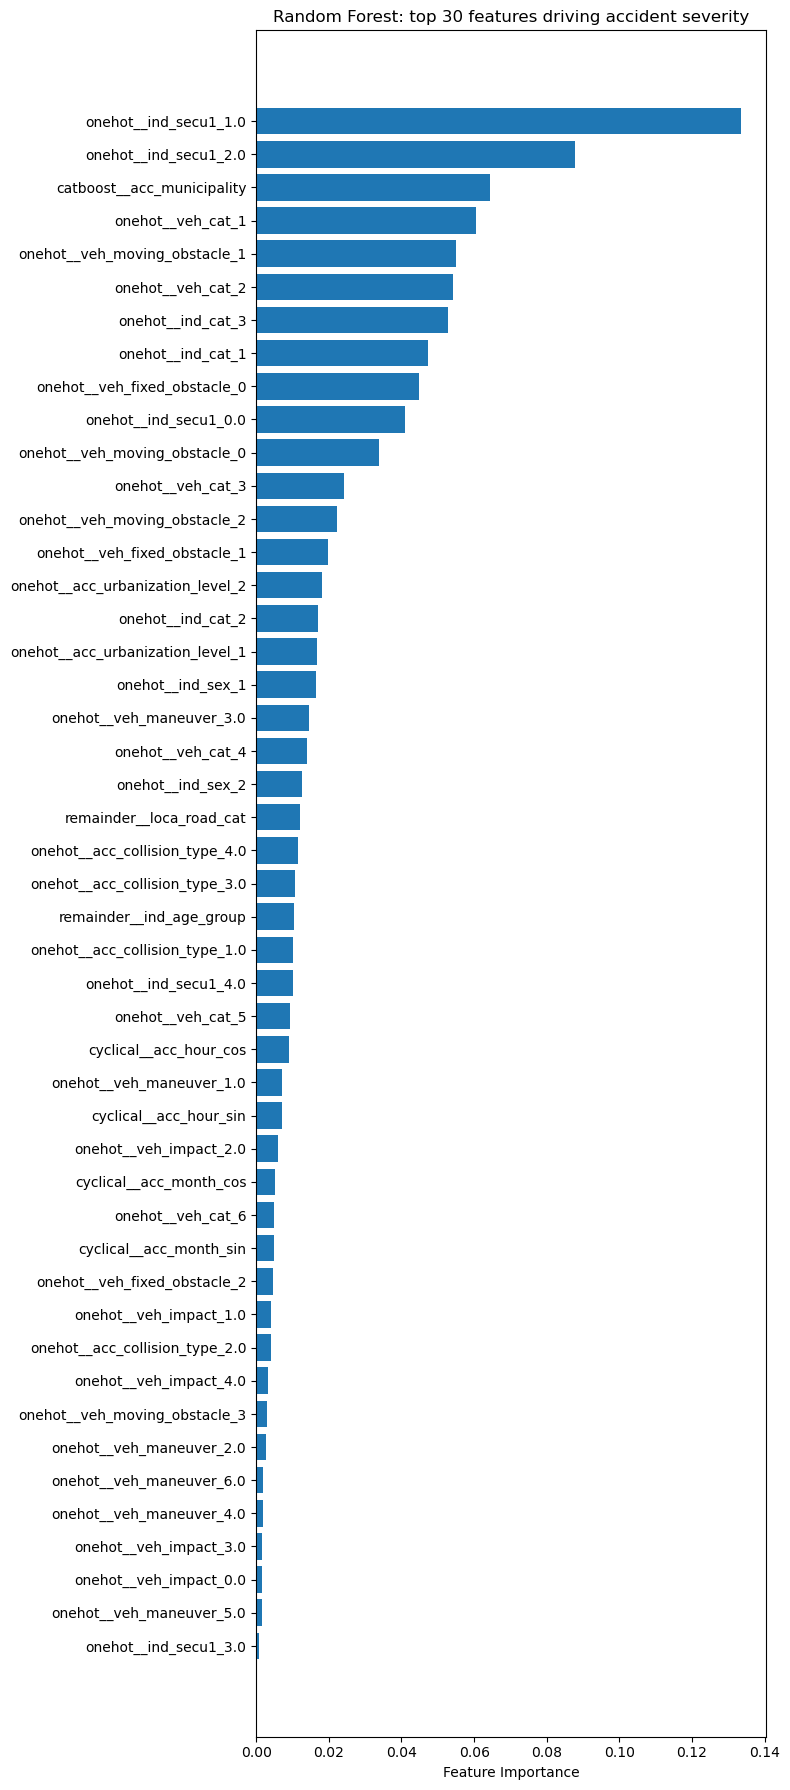

In [39]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")

# accuracy score to check if overfitted
print("Accuracy train:", accuracy_score(y_train, y_train_pred_best))
print("Accuracy test:", accuracy_score(y_test, y_test_pred_best))

# classifiction report
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_best))

# confustion matrix
display(pd.crosstab(y_test, y_test_pred_best, rownames=["Actual"], colnames=["Predicted"]))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# pipline has np.array as output -> for feature_names a pd.DataFrame must be created to plot feature_importances_
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
#feature_names = preprocessing_pipeline.get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)

# Get feature importances from the trained RandomForest
importances = best_rf.feature_importances_
#feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:150]  # top 150

plt.figure(figsize=(8, 18))
plt.barh(range(len(indices)), importances[indices][::-1], align="center", height=0.8)
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: top 30 features driving accident severity")
plt.tight_layout()
plt.show()

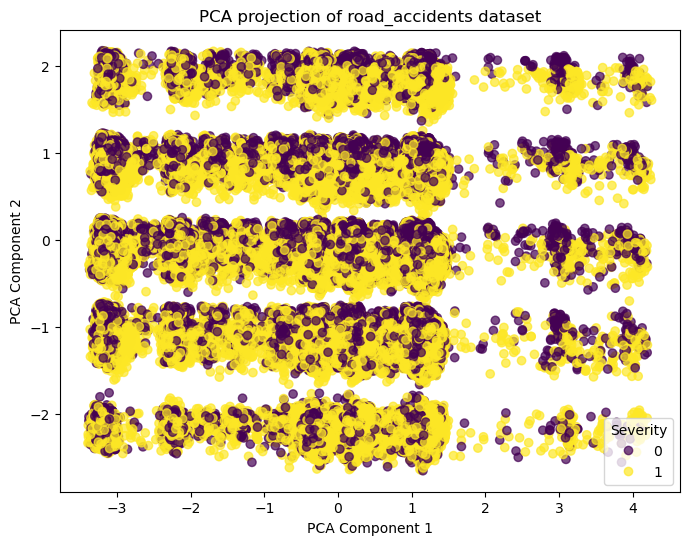

In [35]:
# PCA

pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test_piped)

# Plot with true labels
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA projection of road_accidents dataset")
plt.legend(*scatter.legend_elements(), title="Severity")
plt.show()



In [36]:
# function to export metrics from fitted model
def export_metrics_joblib(model, X_train, y_train, X_test, y_test, out_path):
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Reports
    report_train = classification_report(y_train, y_pred_train, output_dict=True)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    # Collect metrics (only macro f1 und recall from  report)
    metrics = {
        "train": {
            "macro_f1": report_train["macro avg"]["f1-score"],
            "recall": report_train["macro avg"]["recall"]
        },
        "test": {
            "macro_f1": report_test["macro avg"]["f1-score"],
            "recall": report_test["macro avg"]["recall"],
            "per_class": report_test
        },
        "confusion_matrix": confusion_matrix(y_test, y_pred_test).tolist()
    }
    # Feature importance
    if hasattr(model, "feature_importances_"):
        try:
            features = model.feature_names_in_
        except AttributeError:
            features = [f"f{i}" for i in range(len(model.feature_importances_))]
        fi = pd.DataFrame({
            "feature": features,
            "importance": model.feature_importances_
        })
        metrics["feature_importance"] = fi.to_dict(orient="list")
    # Ensure directory exists
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # Save with joblib
    dump(metrics, out_path)
    print(f":weißes_häkchen: Saved metrics (macro F1 & recall focus) to {out_path}")

In [43]:
# export metrics from fitted model
import os
export_metrics_joblib(
    best_rf,
    X_train_piped_df, y_train,
    X_test_piped_df, y_test,
    "C:/Users/Christian/Documents/metrics_rf_binary_final.joblib"
    #"/../../src/streamlit/metrics_rf_binary_final.joblib"
)

:weißes_häkchen: Saved metrics (macro F1 & recall focus) to C:/Users/Christian/Documents/metrics_rf_binary_final.joblib


In [19]:
# --------------------------------------------------------------------------------------------------
# safe fitted model
# --------------------------------------------------------------------------------------------------
dump(best_rf, "../../models/model_rf_2019_2024_binary.joblib", compress=5)
#dump(best_rf, "C:/Users/Christian/Documents/model_rf_over_under_2019_2023.joblib", compress=3)


['../../models/model_rf_2019_2024_binary.joblib']

In [20]:
# --------------------------------------------------------------------------------------------------
# safe fitted pipeline
# --------------------------------------------------------------------------------------------------
dump(preprocessing_pipeline, "../../models/pipeline_rf_2019_2024.joblib", compress=5)
#dump(preprocessing_pipeline, "C:/Users/Christian/Documents/pipeline_rf_over_under_2019_2023.pkl", compress=3)


['../../models//pipeline_rf_over_under_2019_2023.pkl']

In [21]:
# --------------------------------------------------------------------------------------------------
# stratified sample for SHAP values 
# --------------------------------------------------------------------------------------------------
# stratified sample for model explaining
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=30000, stratify=y, random_state=42)

# transform sample the EXACT same way like the fitted model -> very important, otherwise SHAP values do not work
X_sub_clean = preprocessing_pipeline.transform(X_sub)
X_sub_clean = np.array(X_sub_clean, dtype=np.float64)


ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']


In [22]:
# -------------------------------------------------------------------------------------------------------------
# SHAP value computation for binary classification
# -------------------------------------------------------------------------------------------------------------
# Store feature names from pipeline
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
all_features = list(feature_names)

# DataFrame for easier evaluation later
X_sub_df = pd.DataFrame(X_sub_clean, columns=feature_names)

# Explainer object (binary classification)
explainer_new = shap.Explainer(best_rf, X_sub_clean)

# Compute SHAP values (binary: shape = [n_samples, n_features, 2])
shap_values_new = explainer_new(X_sub_clean, check_additivity=False, approximate=True)

# Attach feature names
shap_values_new.feature_names = feature_names

# For binary classification: use the positive class (index 1)
shap_values_binary = shap_values_new.values[:, :, 1]



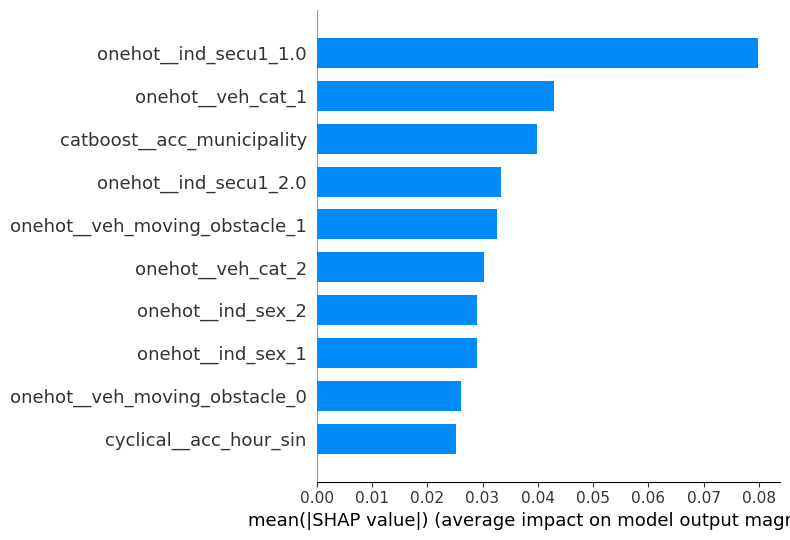

In [23]:
# bar plot for global importance
shap.summary_plot(
    shap_values_binary,
    features=X_sub_clean,
    feature_names=feature_names,
    plot_type='bar',
    max_display=10
)


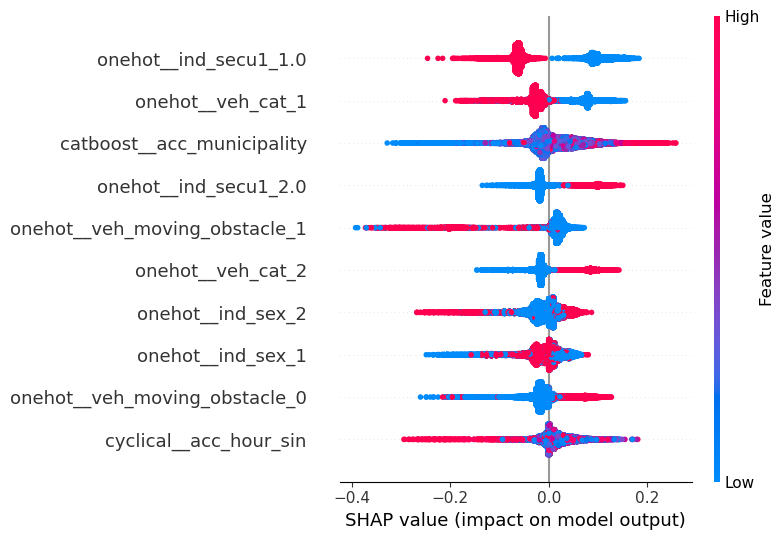

In [24]:
# dot plot with details
shap.summary_plot(
    shap_values_binary,
    features=X_sub_clean,
    feature_names=feature_names,
    plot_type='dot',
    max_display=10
)


In [25]:
class BinaryShapOneHotAggregator:
    """
    Aggregate SHAP values of one-hot and cyclical encoded features back to their original feature.
    Works for binary classification by selecting the positive class (index 1).
    """

    def __init__(self, feature_names, prefix="onehot__", cyclical_prefix="cyclical__"):
        self.feature_names = feature_names
        self.prefix = prefix
        self.cyclical_prefix = cyclical_prefix
        self.groups = self._build_groups()

    def _build_groups(self):
        groups = {}
        for fname in self.feature_names:
            if fname.startswith(self.prefix):
                # One-hot encoded
                base = fname[len(self.prefix):]
                parent = base.rsplit("_", 1)[0]
                groups.setdefault(parent, []).append(fname)
            elif fname.startswith(self.cyclical_prefix):
                # Cyclical encoded (_sin/_cos)
                parent = fname.rsplit("_", 1)[0]  # remove _sin/_cos
                groups.setdefault(parent, []).append(fname)
            else:
                # Continuous or already atomic
                groups.setdefault(fname, [fname])
        return groups

    def aggregate(self, shap_values, data, base_values=None, binary_class=1):
        """
        Aggregate SHAP values back to original features.
        For binary classification, select shap_values[:,:,binary_class].
        """
        has_classes = shap_values.ndim == 3
        agg_list, agg_feature_names = [], []

        for parent, children in self.groups.items():
            idxs = [self.feature_names.index(ch) for ch in children]

            if has_classes:
                if shap_values.shape[2] == 2:  # binary case
                    agg_vals = shap_values[:, idxs, binary_class].sum(axis=1)
                else:  # multiclass case
                    agg_vals = shap_values[:, idxs, :].sum(axis=1)
            else:
                agg_vals = shap_values[:, idxs].sum(axis=1)

            agg_list.append(agg_vals)
            agg_feature_names.append(parent)

        # Stack aggregated values
        if has_classes and shap_values.shape[2] == 2:
            agg_values = np.column_stack(agg_list)  # binary → 2D
        elif has_classes:
            agg_values = np.stack(agg_list, axis=1)  # multiclass → 3D
        else:
            agg_values = np.column_stack(agg_list)

        # Collapse data
        X_df = pd.DataFrame(data, columns=self.feature_names)
        agg_data = pd.DataFrame(index=X_df.index)
        for parent, children in self.groups.items():
            if parent.startswith("cyclical__") and len(children) == 2:
                # Collapse sin/cos into magnitude
                agg_data[parent] = np.sqrt(X_df[children[0]]**2 + X_df[children[1]]**2)
            elif len(children) > 1 and children[0].startswith(self.prefix):
                # Collapse one-hot back to category
                agg_data[parent] = X_df[children].idxmax(axis=1).str.replace(f"{parent}_", "")
            else:
                agg_data[parent] = X_df[children[0]]

        explainer_agg = shap.Explanation(
            values=agg_values,
            base_values=base_values,
            data=agg_data.values,
            feature_names=agg_feature_names
        )
        return explainer_agg, self.groups

In [26]:
# Correct instantiation
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out().tolist()

aggregator = BinaryShapOneHotAggregator(feature_names)   # <-- use the new class here

shap_agg, groups = aggregator.aggregate(
    shap_values_new.values,
    X_sub_clean,
    base_values=shap_values_new.base_values,
    binary_class=1
)

print(shap_agg.values.shape)  # (n_samples, n_features_new)
print(shap_agg.data.shape)    # (n_samples, n_features_new)



(30000, 13)
(30000, 13)


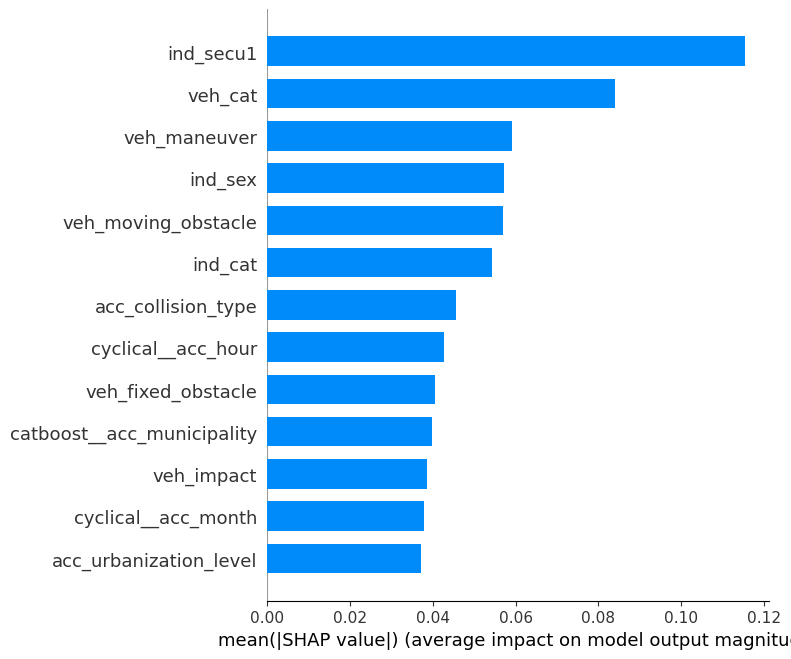

In [28]:
# aggregated features: bar plot with global importance
shap.summary_plot(
    shap_agg.values,
    features=shap_agg.data,
    feature_names=shap_agg.feature_names,
    plot_type="bar",
    max_display=20
)


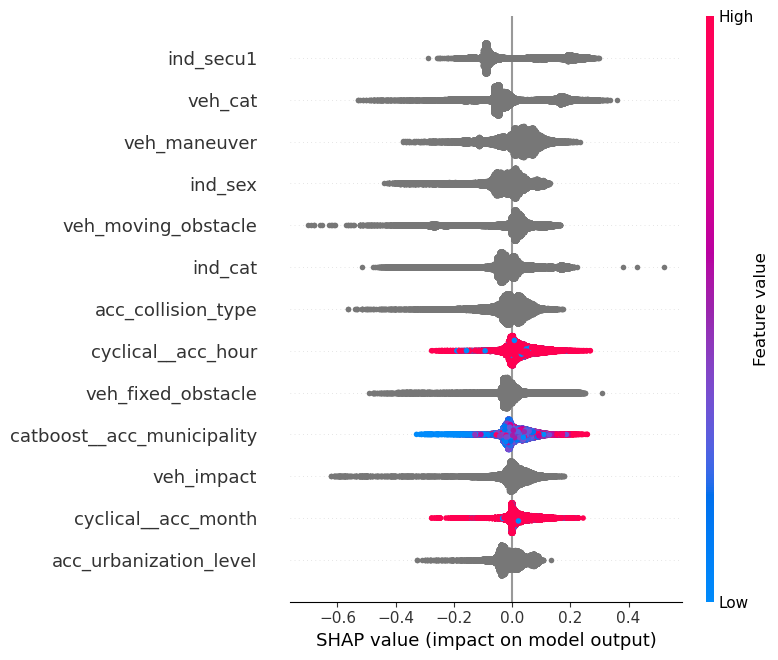

In [29]:
# aggregated features: dot plot with details
shap.summary_plot(
    shap_agg.values,          # aggregated SHAP values
    features=shap_agg.data,   # aggregated feature data
    feature_names=shap_agg.feature_names,
    plot_type="dot",
    max_display=20
)


In [31]:
# --------------------------------------------------------------------------------------------------
# stratified sample for SHAP values 
# --------------------------------------------------------------------------------------------------
# stratified sample for model explaining
X_sub, _, y_sub, _ = train_test_split(X, y, train_size=500, stratify=y, random_state=42)

# transform sample the EXACT same way like the fitted model -> very important, otherwise SHAP values do not work
X_sub_clean = preprocessing_pipeline.transform(X_sub)
X_sub_clean = np.array(X_sub_clean, dtype=np.float64)

ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']


In [ ]:
# Tree-based explainer
explainer = shap.TreeExplainer(best_rf)

# Compute interaction values
shap_interactions = explainer.shap_interaction_values(X_sub_clean)

print(shap_interactions.shape)
# (n_samples, n_features, n_features)